In [1]:
import sys
sys.path.append('../../code/hnn_beta')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, hnn_beta_param_function, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../../data/hnn_beta'

with open(f'{data_path}/posteriors/hnn_beta_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/hnn_beta_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples'] 

In [2]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

dist_var:(0, 40) prox_var:(0, 40) dist_exc:(-7, -4) prox_exc:(-7, -4) 

### Generate conditioning waveform

In [3]:
net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net)

In [4]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond = np.array([0.25, 0.5, 0.75, 0.75])

theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
              idx, (param_name, param_dict) in enumerate(prior_dict.items())}

x_cond = simulator(torch.tensor(theta_cond).float()).numpy()
x_cond = x_cond[:,0,:]
x_cond[:, :zero_samples] = np.repeat(x_cond[:, zero_samples], zero_samples).reshape(x_cond.shape[0], zero_samples)


print(theta_dict)

{'dist_var': 10.0, 'prox_var': 20.0, 'dist_exc': 1.778279410038923e-05, 'prox_exc': 1.778279410038923e-05}
joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation t

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_beta/../../code/hnn_beta/utils.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


Text(0, 0.5, 'Dipole (nAm)')

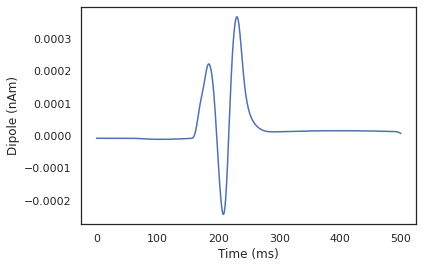

In [6]:
%matplotlib inline
t_vec = np.linspace(0, tstop, x_cond.shape[1])
plt.plot(t_vec, x_cond.squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')

### Load trained posterior objects

In [7]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_orig = x_orig[:,0,:]

load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                    'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
             for name, posterior_dict in posterior_state_dicts.items()}

posterior_names = list(posterior_state_dicts.keys())
print(posterior_names)

['pca30']


In [8]:
name_idx = 0 # Pick posterior to load

input_type = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[input_type]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

posterior = load_posterior(state_dict=state_dict,
                           x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                           theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

### Draw samples and plot

Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

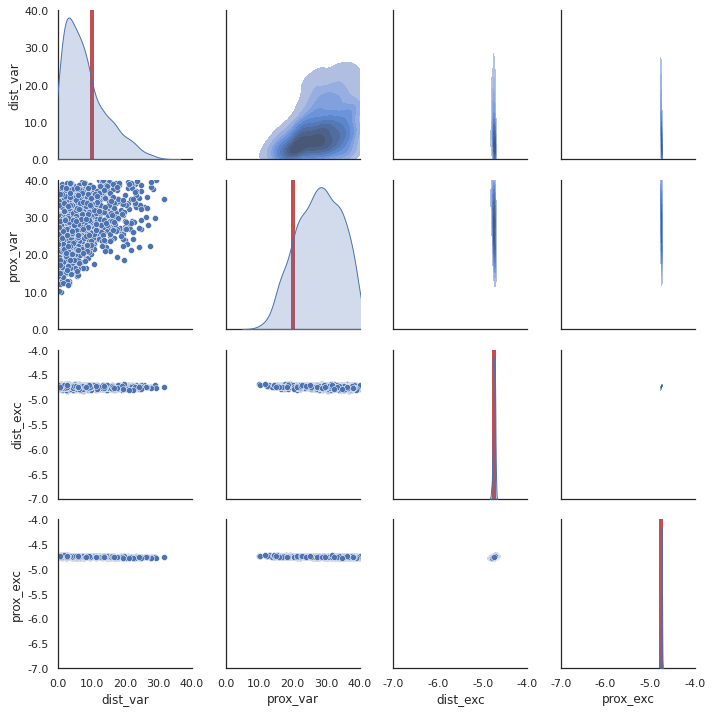

In [9]:
print(f'Conditioning Feature: {posterior_names[name_idx]}')
num_samples = 1000

all_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]

df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}


df = pd.DataFrame(df_dict)

g = sns.PairGrid(df,  diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(4):
    g.axes[idx, idx].axvline(theta_cond_transformed[idx], color='r', linewidth=4) 
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

for idx1 in range(4):
    for idx2 in range(4):
        g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()